# San Francisco v4

The goal of this notebook is to explore ways to group tweets, different preprocessing methods, and different models using TFIDF vectors.

Changes / Ideas:
- No stop words because our approach is similar to sentiment analysis (https://github.com/VinAIResearch/BERTweet#preprocess)

In [1]:
import os
from datetime import datetime
import sys

sys.path.append("../scripts/twitter")
from searchTwitter import TwitterDataFrame

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import re

import nltk
import emoji

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score

from imblearn import over_sampling
from imblearn import under_sampling

np.random.seed(23)

# Set up sns
sns.set(rc = {'figure.figsize':(10,10)})
sns.set_style("whitegrid")

In [2]:
# Reads files in a directory as csv and returns dataframe
def concat_data(base_dir):
    files = os.listdir(base_dir)
    dfs = []
    for f in files:
        dfs.append(pd.read_csv(base_dir + f))
        
    return pd.concat(dfs)

sf_df_raw = concat_data('../data/san_francisco/')

# Turn into a TwitterDataFrame and zoom in on san francisco
sf_df_raw = TwitterDataFrame(sf_df_raw)

sf_df_raw.head()

C:\Users\Nick\AppData\Local\Temp/ipykernel_4448/3815770650.py:6: DtypeWarning: Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs.append(pd.read_csv(base_dir + f))


,id,author_id,text,geo,created_at,lat,lon
0,968999128641323008,25624940,@Volker_E Am I hallucinating that you are walk...,{'place_id': '5a110d312052166f'},2018-02-28 23:59:30,37.708075,-122.514926
1,968999100757680128,8888,There’s just something weird about living in N...,{'place_id': '5ef5b7f391e30aff'},2018-02-28 23:59:23,37.845953,-122.324818
2,968999065273774080,1557223812,Tomorrow’s March sheeeesh I’m basically 24 😕 t...,{'place_id': '5ecbd073f39c00fa'},2018-02-28 23:59:14,37.592632,-122.160814
3,968999056537088000,1164993320,Wednesday really be draining 6-6 school day 😴,{'place_id': '5ecbd073f39c00fa'},2018-02-28 23:59:12,37.592632,-122.160814
4,968999038493245440,18650764,@remedy415 @Brycesavoy510 This hella dope,{'place_id': 'ab2f2fac83aa388d'},2018-02-28 23:59:08,37.699279,-122.342660


In [3]:
sf_df_raw = sf_df_raw.dropna().reset_index(drop=True)
 
sf_df_raw['created_at'] = [datetime.strptime(d,'%Y-%m-%d %H:%M:%S') for d in sf_df_raw['created_at']]

# Subset 5/2018-12/2018
sf_df_raw = sf_df_raw[sf_df_raw['created_at'] > datetime(2018, 4, 30)]

# Change date quantum to day
sf_df_raw['date'] = sf_df_raw['created_at'].dt.floor('d')

sf_df = TwitterDataFrame(sf_df_raw)
sf_df.head()

,id,author_id,text,geo,created_at,lat,lon,date
439249,1002338864273346561,1637084264,mines the 86 for MBTA and the 33 for MUNI,{'place_id': '5a110d312052166f'},2018-05-31 23:59:42,37.708075,-122.514926,2018-05-31
439250,1002338849979187201,2276720725,If you don’t need work over the summer conside...,{'place_id': '5a110d312052166f'},2018-05-31 23:59:39,37.708075,-122.514926,2018-05-31
439251,1002338749919870976,391204136,@varadhjain 1. Practice 2. Observe those who a...,{'place_id': '5a110d312052166f'},2018-05-31 23:59:15,37.708075,-122.514926,2018-05-31
439252,1002338701127573504,111136252,I heard one of the coldest things in a long ti...,{'place_id': '5a110d312052166f'},2018-05-31 23:59:03,37.708075,-122.514926,2018-05-31
439253,1002338641505443841,783713395,@realDonaldTrump Talking about being treated u...,{'place_id': 'a769d8f00b12878d'},2018-05-31 23:58:49,37.565624,-122.515276,2018-05-31


In [4]:
# Read in the daily AQI in 2018 California
aqi_2018 = pd.read_csv('../data/daily_aqi_by_county_2018.csv')

# Subset just SF country and extract dates
sf_aqi = aqi_2018[(aqi_2018['State Name']=='California') & (aqi_2018['county Name']=='San Francisco')]
sf_aqi['Date'] = pd.to_datetime(sf_aqi['Date'])

sf_aqi.head()

C:\Users\Nick\AppData\Local\Temp/ipykernel_4448/2893133138.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sf_aqi['Date'] = pd.to_datetime(sf_aqi['Date'])


,State Name,county Name,State Code,County Code,Date,AQI,Category,Defining Parameter,Defining Site,Number of Sites Reporting
27443,California,San Francisco,6,75,2018-01-01,72,Moderate,PM2.5,06-075-0005,1
27444,California,San Francisco,6,75,2018-01-02,82,Moderate,PM2.5,06-075-0005,1
27445,California,San Francisco,6,75,2018-01-03,111,Unhealthy for Sensitive Groups,PM2.5,06-075-0005,1
27446,California,San Francisco,6,75,2018-01-04,58,Moderate,PM2.5,06-075-0005,1
27447,California,San Francisco,6,75,2018-01-05,26,Good,NO2,06-075-0005,1


In [5]:
# What are the basics of tlos data set?
print("Lenth: ", len(sf_df))
print("Per day :", len(sf_df)/365)

Lenth:  1801077
Per day : 4934.457534246575


In [6]:
spec_re = "[^A-Za-z0-9\@]+"
http_re = "https?:\S+|http?:\S"
at_re = "@\S+"

def process_tweet(tweet):
    tweet = str(tweet).lower()
    tweet = emoji.demojize(tweet)
    tweet = re.sub(spec_re, ' ', tweet)
    tweet = re.sub(http_re, 'HTTPURL', tweet)
    tweet = re.sub(at_re, '@USER', tweet)    
    tweet = re.sub(r'\s+', ' ', tweet).strip()
    return tweet

sf_df['text'] = sf_df['text'].apply(process_tweet)

sf_df.head()

,id,author_id,text,geo,created_at,lat,lon,date
439249,1002338864273346561,1637084264,mines the 86 for mbta and the 33 for muni,{'place_id': '5a110d312052166f'},2018-05-31 23:59:42,37.708075,-122.514926,2018-05-31
439250,1002338849979187201,2276720725,if you don t need work over the summer conside...,{'place_id': '5a110d312052166f'},2018-05-31 23:59:39,37.708075,-122.514926,2018-05-31
439251,1002338749919870976,391204136,@USER 1 practice 2 observe those who are good ...,{'place_id': '5a110d312052166f'},2018-05-31 23:59:15,37.708075,-122.514926,2018-05-31
439252,1002338701127573504,111136252,i heard one of the coldest things in a long ti...,{'place_id': '5a110d312052166f'},2018-05-31 23:59:03,37.708075,-122.514926,2018-05-31
439253,1002338641505443841,783713395,@USER talking about being treated unfairly wha...,{'place_id': 'a769d8f00b12878d'},2018-05-31 23:58:49,37.565624,-122.515276,2018-05-31


In [7]:
sf_batch = TwitterDataFrame(sf_df).group_by_day_and_batch(1200)
sf_batch.shape

(1630, 2)

In [8]:
sf_mrg = pd.merge(left=sf_batch, right=sf_aqi, left_on='date', right_on='Date', how='inner')

In [9]:
sf_mrg.columns

Index(['date', 'text', 'State Name', 'county Name', 'State Code',
       'County Code', 'Date', 'AQI', 'Category', 'Defining Parameter',
       'Defining Site', 'Number of Sites Reporting'],
      dtype='object')

In [10]:
sf_clean = sf_mrg.drop(columns=['State Name', 'county Name', 'State Code', 'County Code', 'Date', "Defining Parameter", "Defining Site", "Number of Sites Reporting"])

sf_clean.to_csv("../data/sf_cleaned.csv", index=False)

sf_clean.head()

,date,text,AQI,Category
0,2018-05-01,@USER can t remember where you said your recep...,37,Good
1,2018-05-01,@USER @ amychang samesies @USER @USER @USER @U...,37,Good
2,2018-05-01,@USER @USER me too face with tears of joy hope...,37,Good
3,2018-05-01,dad joke satori this am 4yo i m tired me hi ti...,37,Good
4,2018-05-01,yoooo i alreayd loves wolves but now i love th...,37,Good


#### Note: to start from previously cleaned data begin here

In [11]:
sf_clean = pd.read_csv("../data/cleaned/sf_cleaned.csv", parse_dates=['date'])
sf_clean.head()

,date,text,AQI,Category
0,2018-05-01,@USER @USER that s the neighborhood i grew up ...,37,Good
1,2018-05-01,@USER i ain t seen one meme from u smh i m wai...,37,Good
2,2018-05-01,birthday month love you gesture medium dark sk...,37,Good
3,2018-05-01,@USER io @USER only problem is it may be too h...,37,Good
4,2018-05-01,the american dream narrative system wasn t cre...,37,Good


#### Experiment: word counts

In [12]:
word_freq = sf_clean.text.str.split(expand=True).stack().value_counts()
word_count = word_freq.sum()
word_freq

@USER            1960725
i                 861179
the               845483
to                637867
a                 547576
                  ...   
biostream?             1
wowwwww!!!!!!          1
0brien                 1
1?!?!?                 1
clownstick             1
Length: 371168, dtype: int64

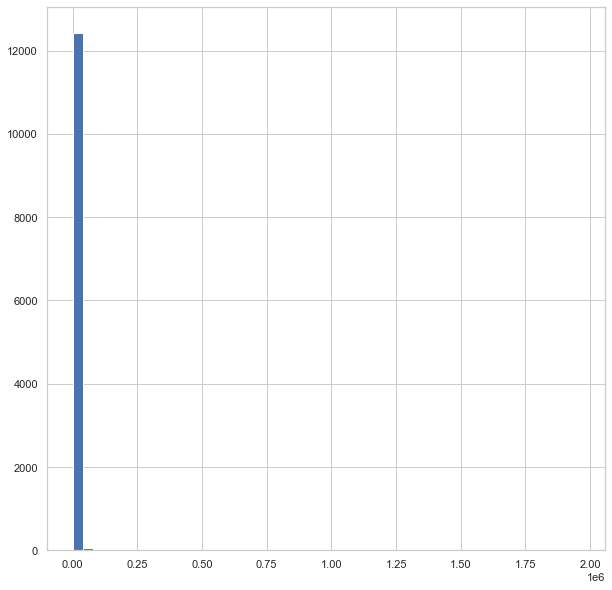

In [13]:
plt.hist(word_freq, bins=50, range=[word_freq.min()+100, word_freq.max()]);

In [14]:
# Fire increased a lot when I added emojis 🔥
key_words = ["asthma","lung","cough","smoke","fire", "smog","aqi","air"]
key_freq = word_freq[key_words]
key_freq, word_count

(asthma      122
 lung         92
 cough       462
 smoke      3269
 fire      15374
 smog         71
 aqi          73
 air        4094
 dtype: int64,
 30608200)

In [15]:
min_df = key_freq.min() / word_count
max_df = key_freq.max() / word_count + 0.05

min_df, max_df

(2.319639835076875e-06, 0.05050228370175313)

### Model Code below

In [16]:
train_df, test_df = train_test_split(sf_clean, test_size=0.2, random_state=23)
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

In [17]:
# This creates a train-test split based off of days
dates = sf_clean.date.unique()
np.random.shuffle(dates)
train_dates, test_dates = train_test_split(dates, test_size=0.2, random_state=23)
train_df = sf_clean[sf_clean['date'].isin(train_dates)]
test_df = sf_clean[sf_clean['date'].isin(test_dates)]

In [18]:
train_df.head()

,date,text,AQI,Category
0,2018-05-01,@USER @USER that s the neighborhood i grew up ...,37,Good
1,2018-05-01,@USER i ain t seen one meme from u smh i m wai...,37,Good
2,2018-05-01,birthday month love you gesture medium dark sk...,37,Good
3,2018-05-01,@USER io @USER only problem is it may be too h...,37,Good
4,2018-05-01,the american dream narrative system wasn t cre...,37,Good


In [19]:
X_train = train_df['text']
X_test = test_df['text']

y_train = train_df['AQI']
y_test = test_df['AQI']

### Experiment 1: Word importances with random forest.

In [20]:
# min_df sets the min document frequency for accepted words
tf_vect = TfidfVectorizer(min_df=min_df, max_df=max_df).fit(X_train)
words = tf_vect.get_feature_names_out()
X_train_enc = tf_vect.transform(X_train)
X_test_enc = tf_vect.transform(X_test)

In [21]:
X_train_enc.shape, X_train.shape

((1534, 241577), (1534,))

In [22]:
y_train = train_df['AQI'].apply(np.log2)
y_test = test_df['AQI'].apply(np.log2)
y_train

0       5.209453
1       5.209453
2       5.209453
3       5.209453
4       5.209453
          ...   
1918    4.906891
1919    4.906891
1920    4.906891
1921    4.906891
1922    4.906891
Name: AQI, Length: 1534, dtype: float64

In [23]:
from sklearn.ensemble import RandomForestRegressor

tree_model = RandomForestRegressor(random_state=23, n_estimators=20).fit(X_train_enc, y_train)

In [24]:
tree_model.score(X_train_enc, y_train)


0.9519425989872412

In [25]:
tree_model.score(X_test_enc, y_test)

0.3823616639636962

In [26]:
for idx in np.argpartition(tree_model.feature_importances_, -75)[-75:]:
    print(words[idx])


sewer
adschat
conspirator
mlscup
waco
voteclubkane
anes18
osl
steubienorcal
ablc2018
muntot
apa2018
engcol
gerswe
connectcentral18
marinvolleyball
respirator
collateral
cds
gorb
woodward
jn17
mortgaging
shareyourrejections
cyberpunk
tbs
oscars
dreamforce2018
pecker
idweek2018
pescfall18summit
glowy
outsidelands
game7
df18
accuser
abalel
vote2018
loveloud
aqi
treasonsummit
butte
wellstonedems
be3
revengeful
signalconf
machina
worldseries
gomes
civilrights
csk8
rwc7s
amersa2018
comicsgate
amia2018
cometsfootball
shethepeople18
afrotech
americain3words
muncy
survivorseries
kroqxmas
santacon
chromedevsummit
sharpobjects
californiawildfires
n95
livermtg18
roethlisberger
veteransday
debh
wimbledon
crazyrichasians
evacuated
radford


#### Experiment 2: Fitting the model with K-neighbors 

In [27]:
from sklearn.neighbors import KNeighborsRegressor

# Fit Regression model
knn_model = KNeighborsRegressor(n_neighbors=5, n_jobs=-1).fit(X_train_enc, y_train)

In [28]:
y_pred = knn_model.predict(X_train_enc)
knn_model.score(X_train_enc, y_train)


0.9896116564781493

In [29]:
y_pred_test = knn_model.predict(X_test_enc)
knn_model.score(X_test_enc, y_test)


0.38640436751152063

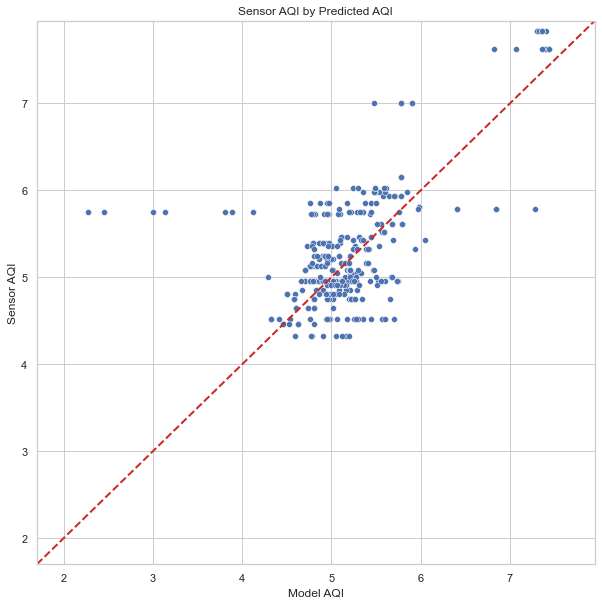

In [30]:
# Plots predictions by their true value
def plot_reference(y_pred, y_train, draw_ref=True):
    # Draw reference lines
    if draw_ref:
        X = np.linspace(0, 240, 240)
        plt.plot(X, X, '--', color="#cc2727", linewidth=2)

    plot = sns.scatterplot(x=y_pred, y=y_train)

    # Set plot style
    max_lim = max(y_pred)
    min_lim = min(y_pred)
    max_lim += (max_lim-min_lim) / 10
    min_lim -= (max_lim-min_lim) / 10

    plot.set(ylim=(min_lim, max_lim))
    plot.set(xlim=(min_lim, max_lim))

    plot.set_title("Sensor AQI by Predicted AQI")
    plot.set_ylabel("Sensor AQI", fontsize = 12)
    plot.set_xlabel("Model AQI", fontsize = 12)

# plot_reference(y_pred, y_train)
plot_reference(y_pred_test, y_test)

##### Interpreting the results

In [31]:
# 0. Ensure the X_train, X_train_enc all have 0-len indexing
from sklearn.feature_extraction.text import CountVectorizer

# 1. Find the date of 5 days with extreme variance
dates = []
for idx in np.argpartition(np.abs(y_pred_test - y_test), -5)[-5:]:
    dates.append(train_df.iloc[idx]['date'])
dates = set(dates)

hi_vals = []
lo_vals = []

# 2. Find the X_train of the min and max predict vals of those days
for date in dates:
    date_batches = train_df[train_df['date'] == date]
    hi_vals.append(X_train[np.argmax(y_pred[date_batches.index])])
    lo_vals.append(X_train[np.argmin(y_pred[date_batches.index])])

hi_vals = [' '.join(hi_vals)]
lo_vals = [' '.join(lo_vals)]

# 3. Compare the distributions of the 5 min and the 5 max
words = CountVectorizer().fit(hi_vals)
hi_dist = words.transform(hi_vals).toarray()
lo_dist = words.transform(lo_vals).toarray()

hi_idx = np.fliplr(hi_dist.argsort())
lo_idx = np.fliplr(lo_dist.argsort())

words = words.get_feature_names_out()[hi_idx].reshape((-1,))

hi_dist = hi_dist.T[hi_idx].reshape((-1,))
lo_dist = lo_dist.T[lo_idx].reshape((-1,))

In [32]:
#plt.bar(words.tolist(), hi_dist)
words.shape, hi_dist.shape, lo_dist.shape

((3737,), (3737,), (3737,))

In [33]:
hi_dist_norm = np.divide(np.abs(hi_dist - lo_dist - 1), hi_dist)
# hi_dist_norm = np.abs(hi_dist/np.sum(hi_dist) - lo_dist/np.sum(lo_dist))
for idx in np.argpartition(hi_dist_norm, -25)[-25:]:
    print(words[idx])

eagerly
dummy
ea
baptism
banter
bart
early
dunkin
elo
basket
bassist
dudes
bath
economist
bae
education
effect
auto
automating
embarrassed
emailmarketing
avengers
awaiting
elon
000


### Experiment 2b: Testing batch sizes
> To run this make sure to have done the entire data cleaning step not just loading in the cleaned csv.

In [34]:
scores = []
batch_sizes = [] #[800, 1000, 1200, 1400, 1600, 1800, 2000]
for batch_size in batch_sizes:
    batch = TwitterDataFrame(sf_df).group_by_day_and_batch(batch_size)
    batch.shape

    mrg = pd.merge(left=batch, right=sf_aqi, left_on='date', right_on='Date', how='inner')

    clean = mrg.drop(columns=['State Name', 'county Name', 'State Code', 'County Code', 'Date', "Defining Parameter", "Defining Site", "Number of Sites Reporting"])

    train_df, test_df = train_test_split(clean, test_size=0.2, random_state=23)
    train_df = train_df.reset_index(drop=True)
    test_df = test_df.reset_index(drop=True)

    X_train = train_df['text']
    X_test = test_df['text']

    y_train = train_df['AQI']
    y_test = test_df['AQI']

    # min_df sets the min document frequency for accepted words
    tf_vect = TfidfVectorizer(min_df=2).fit(X_train)
    X_train_enc = tf_vect.transform(X_train)
    X_test_enc = tf_vect.transform(X_test)

    # Fit Regression model
    knn_model = KNeighborsRegressor(n_neighbors=5, n_jobs=-1).fit(X_train_enc, y_train)
    y_pred = knn_model.predict(X_train_enc)
    y_pred_test = knn_model.predict(X_test_enc)
    
    scores.append((knn_model.score(X_train_enc, y_train), knn_model.score(X_test_enc, y_test)))



Text(0.5, 1.0, '$R^2$ by Batch Size')

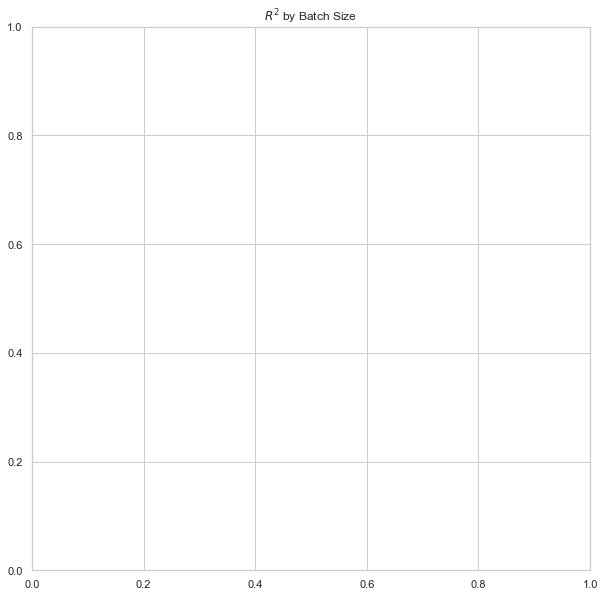

In [35]:
score_df = pd.DataFrame(data=scores, index=batch_sizes, columns=["Training R^2", "Testing R^2"])
plt = sns.lineplot(data=score_df)
plt.set_title("$R^2$ by Batch Size")

### Experiment 3: Fitting the model with MLP

In [36]:
X_train_enc.shape

(1534, 241577)

In [37]:
from sklearn.neural_network import MLPRegressor

# Fit Regression model
hidden_layer_sizes=(32,32,)
num_params = X_test_enc.shape[1] * hidden_layer_sizes[0]
for i in range(len(hidden_layer_sizes)-1):
    num_params += hidden_layer_sizes[i] * hidden_layer_sizes[i+1]
num_params += hidden_layer_sizes[-1]

print("~Total parameters: {}".format(num_params))


mlp_model = MLPRegressor(hidden_layer_sizes=(1000,), random_state=23, verbose=1, n_iter_no_change=2).fit(X_train_enc, y_train)


~Total parameters: 7731520
Iteration 1, loss = 8.89793627
Iteration 2, loss = 0.80220315
Iteration 3, loss = 1.25566652
Iteration 4, loss = 0.18986233
Iteration 5, loss = 0.29180167
Iteration 6, loss = 0.06069159
Iteration 7, loss = 0.07102554
Iteration 8, loss = 0.02070246
Iteration 9, loss = 0.02248712
Iteration 10, loss = 0.01043373
Iteration 11, loss = 0.00930614
Iteration 12, loss = 0.00713966
Iteration 13, loss = 0.00619022


C:\Users\Nick\miniconda3\envs\bergin\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:699: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


In [38]:
y_pred = mlp_model.predict(X_train_enc)
mlp_model.score(X_train_enc, y_train)


0.9837529048380678

In [39]:
y_pred_test = mlp_model.predict(X_test_enc)
mlp_model.score(X_test_enc, y_test)


0.002141400000432947